# **1. Environment Setup & Imports**

In [7]:
!pip install medmnist

import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
import medmnist
from medmnist import INFO
import matplotlib.pyplot as plt

# Configuration
DATA_FLAG = 'dermamnist'
BATCH_SIZE = 128
EPOCHS = 10  # Increased for better convergence
LR = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


# **2. Data Pipeline**

In [8]:
info = INFO[DATA_FLAG]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

# Standardize statistics for DermaMNIST
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_dataset = DataClass(split='train', transform=data_transform, download=True)
test_dataset = DataClass(split='test', transform=data_transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Single batch size for latency benchmarking
benchmark_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)

# **3. Model Architecture (Quantization-Aware)**

In [9]:
class QuantizableResNet18(nn.Module):
    def __init__(self, n_classes):
        super(QuantizableResNet18, self).__init__()
        # Load quantization-ready ResNet backbone
        self.model = models.quantization.resnet18(weights=None, quantize=False)

        # Adapt input layer for 28x28 grayscale/RGB images
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, n_classes)

    def forward(self, x):
        return self.model(x)

    def fuse_model(self):
        """Fuse Conv+BN+ReLU modules for optimization."""
        self.model.fuse_model()

model = QuantizableResNet18(n_classes=n_classes).to(device)

# **4. Training Loop (FP32 Baseline)**

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting FP32 training...")
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.squeeze().long()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {running_loss/len(train_loader):.4f}")

# Save baseline model
torch.save(model.state_dict(), "model_fp32.pth")
print("Baseline model saved.")

Starting FP32 training...
Epoch 1/10 | Loss: 0.9165
Epoch 2/10 | Loss: 0.7806
Epoch 3/10 | Loss: 0.7342
Epoch 4/10 | Loss: 0.7025
Epoch 5/10 | Loss: 0.6599
Epoch 6/10 | Loss: 0.6207
Epoch 7/10 | Loss: 0.5968
Epoch 8/10 | Loss: 0.5589
Epoch 9/10 | Loss: 0.4817
Epoch 10/10 | Loss: 0.4262
Baseline model saved.


# **5. Static Quantization Pipeline**

In [11]:
# 1. Prepare for Quantization (CPU required)
model.to('cpu')
model.eval()

# 2. Fuse Layers (Conv2d + BatchNorm + ReLU)
model.fuse_model()

# 3. Configure Quantization Backend (fbgemm for x86, qnnpack for ARM/Mobile)
model.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')

# 4. Insert Observers
torch.ao.quantization.prepare(model, inplace=True)

# 5. Calibrate with Training Data
print("Calibrating quantization observers...")
with torch.no_grad():
    for i, (inputs, _) in enumerate(train_loader):
        if i > 20: break  # Calibrate on subset
        model(inputs)

# 6. Convert to Int8
print("Converting to Int8...")
torch.ao.quantization.convert(model, inplace=True)

# Save quantized model
torch.save(model.state_dict(), "model_int8.pth")
print("Quantized model saved.")

/tmp/ipython-input-1653353234.py:12: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.prepare(model, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of P

Calibrating quantization observers...
Converting to Int8...


/tmp/ipython-input-1653353234.py:23: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.convert(model, inplace=True)


Quantized model saved.


# **6. Evaluation & Benchmarking Utility**

In [12]:
def evaluate_model(model_instance, state_dict_path, loader, device='cpu', is_quantized=False):
    """Loads weights and measures Accuracy, Latency, and Size."""

    # Re-setup architecture based on type
    model = model_instance
    if is_quantized:
        model.eval()
        model.fuse_model()
        model.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')
        torch.ao.quantization.prepare(model, inplace=True)
        torch.ao.quantization.convert(model, inplace=True)

    model.load_state_dict(torch.load(state_dict_path, map_location=device))
    model.to(device)
    model.eval()

    # Size
    size_mb = os.path.getsize(state_dict_path) / 1e6

    # Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.squeeze().long().to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = 100 * correct / total

    # Latency (Batch Size 1)
    timings = []
    with torch.no_grad():
        # Warmup
        for i, (inputs, _) in enumerate(benchmark_loader):
            if i >= 5: break
            model(inputs.to(device))
        # Measure
        for i, (inputs, _) in enumerate(benchmark_loader):
            if i >= 100: break
            inputs = inputs.to(device)
            start = time.perf_counter()
            model(inputs)
            timings.append((time.perf_counter() - start) * 1000)

    latency = np.mean(timings)

    return {'Size (MB)': size_mb, 'Latency (ms)': latency, 'Accuracy (%)': accuracy}

# Run Benchmarks
print("Benchmarking FP32 Model...")
metrics_fp32 = evaluate_model(QuantizableResNet18(n_classes), "model_fp32.pth", test_loader, is_quantized=False)

print("Benchmarking Int8 Model...")
metrics_int8 = evaluate_model(QuantizableResNet18(n_classes), "model_int8.pth", test_loader, is_quantized=True)

print(f"\nResults:\nFP32: {metrics_fp32}\nInt8: {metrics_int8}")

Benchmarking FP32 Model...
Benchmarking Int8 Model...


/tmp/ipython-input-3756143285.py:10: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.ao.quantization.prepare(model, inplace=True)
/tmp/ipython-input-3756143285.py:11: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize


Results:
FP32: {'Size (MB)': 44.771467, 'Latency (ms)': np.float64(21.78904347000298), 'Accuracy (%)': 72.86783042394015}
Int8: {'Size (MB)': 11.305825, 'Latency (ms)': np.float64(15.688558429992554), 'Accuracy (%)': 72.81795511221945}


# **7. Visualization**

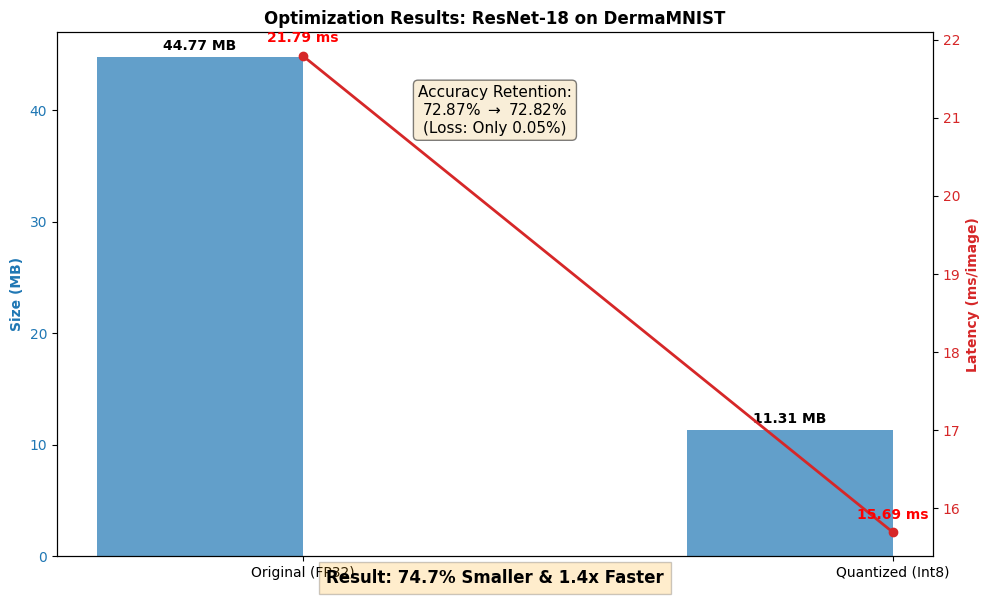

In [14]:
import matplotlib.pyplot as plt
import numpy as np

metrics = {
    'Original (FP32)': {'Size (MB)': 44.77, 'Latency (ms)': 21.79, 'Accuracy (%)': 72.87},
    'Quantized (Int8)': {'Size (MB)': 11.31, 'Latency (ms)': 15.69, 'Accuracy (%)': 72.82}
}

labels = list(metrics.keys())
sizes = [m['Size (MB)'] for m in metrics.values()]
latencies = [m['Latency (ms)'] for m in metrics.values()]
accuracies = [m['Accuracy (%)'] for m in metrics.values()]

x = np.arange(len(labels))
width = 0.35

fig, ax1 = plt.subplots(figsize=(10, 6))

# 1. Plot Size (Bar Chart)
color = 'tab:blue'
bars = ax1.bar(x - width/2, sizes, width, label='Model Size (MB)', color=color, alpha=0.7)
ax1.set_ylabel('Size (MB)', color=color, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Optimization Results: ResNet-18 on DermaMNIST', fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)

# Annotate Bars (Size)
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f} MB',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', fontweight='bold')

# 2. Plot Latency (Line Chart on secondary axis)
ax2 = ax1.twinx()
color = 'tab:red'
ax2.plot(x, latencies, color=color, marker='o', linewidth=2, label='Inference Latency (ms)')
ax2.set_ylabel('Latency (ms/image)', color=color, fontweight='bold')
ax2.tick_params(axis='y', labelcolor=color)

# Annotate Points (Latency)
for i, txt in enumerate(latencies):
    ax2.annotate(f'{txt:.2f} ms', (x[i], latencies[i]),
                 xytext=(0, 10), textcoords='offset points',
                 ha='center', color='red', fontweight='bold')

# 3. Add Accuracy Box
acc_change = accuracies[0] - accuracies[1]
text_str = (f"Accuracy Retention:\n"
            f"{accuracies[0]:.2f}% $\\to$ {accuracies[1]:.2f}%\n"
            f"(Loss: Only {acc_change:.2f}%)")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.5, 0.9, text_str, transform=ax1.transAxes, fontsize=11,
        verticalalignment='top', horizontalalignment='center', bbox=props)

# 4. Add Speedup/Reduction Labels
speedup = latencies[0] / latencies[1]
reduction = (1 - sizes[1]/sizes[0]) * 100

plt.figtext(0.5, 0.02,
            f"Result: {reduction:.1f}% Smaller & {speedup:.1f}x Faster",
            ha="center", fontsize=12, fontweight="bold",
            bbox={"facecolor":"orange", "alpha":0.2, "pad":5})

fig.tight_layout()
plt.show()